In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.metrics.aline import similarity_matrix
from pandas import value_counts
from win32evtlogutil import langid

- kaggle dataset (초안)

In [335]:
book_df=pd.read_csv('data/book_review_data.csv')

In [336]:
# 1) 필요한 컬럼 도출
# 2) 형변환 (float > int)

book_df=book_df[['user_id',"age","rating","book_title",'book_author','year_of_publication','img_m','Summary','Category','country','Language']]
book_df[['age',"year_of_publication"]]=book_df[['age',"year_of_publication"]].astype(int)

In [337]:
# 최소 평가 개수 ( 평가가 30개보다 많은 책만 추출 )
counts=book_df['book_title'].value_counts()
title = counts[counts > 30].index
book_filter_df=book_df[book_df['book_title'].isin(title)]

In [338]:
# 소문자로 만들기
book_filter_df['book_title'] = book_filter_df['book_title'].str.lower()
book_filter_df["Summary"]= book_filter_df['Summary'].str.lower()

C:\Users\playdata2\AppData\Local\Temp\ipykernel_6992\982956339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_filter_df['book_title'] = book_filter_df['book_title'].str.lower()
C:\Users\playdata2\AppData\Local\Temp\ipykernel_6992\982956339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_filter_df["Summary"]= book_filter_df['Summary'].str.lower()


In [339]:
# 최소 평가 개수 ( 평가가 20개보다 많은 사용자만 추출 )
counts=book_filter_df["user_id"].value_counts()
user_id_=counts[counts>10].index
book_filter_df = book_filter_df[book_filter_df['user_id'].isin(user_id_)]

In [340]:
# 무의미한 0점 평가 제거
rating_zero=book_filter_df[book_filter_df['rating']==0].index
book_filter_df.drop(rating_zero, axis=0, inplace=True)

In [341]:
# 한 카테고리안에 책이 5권 미만인 경우 제거
counts=book_filter_df["Category"].value_counts()
categories = counts[counts > 5].index
book_filter_df = book_filter_df[book_filter_df['Category'].isin(categories)]

idx=book_filter_df[book_filter_df["Summary"]=='9'].index
book_filter_df.drop(idx,axis=0,inplace=True)


In [362]:
# book_title에 Summary가 두개 이상인 것들이 있어서 첫번쨰 요약 하나만 남겨두고 나머지 제거
# 중복 개수 확인
# Summary 열에서 중복된 값 중 첫 번째만 남기고 나머지 제거
book_filter_df = book_filter_df.drop_duplicates(subset='Summary', keep='first')

# book_title 열에서 중복된 값 중 첫 번째만 남기고 나머지 제거
book_filter_df = book_filter_df.drop_duplicates(subset='book_title', keep='first')

duplicate_count = book_filter_df['Summary'].duplicated().sum()
print(f"남은 중복된 Summary 개수: {duplicate_count}")
# 책마다 중복되는 써머리 제거
book_filter_df = book_filter_df.drop_duplicates(subset=['book_title', 'Summary'], keep='first')

남은 중복된 Summary 개수: 0


In [364]:
# 중복확인
duplicate_check = book_filter_df.duplicated(subset=['book_title', 'Summary']).sum()
print(f'중복확인:{duplicate_check}')

book_filter_df[['book_title', 'Summary']]  # 3412로 동일하게 됨
unique_book_count = book_filter_df['book_title'].nunique()  # 3450
print(unique_book_count)

unique_summary_count = book_filter_df['Summary'].nunique()  # 4781
print(unique_summary_count)

중복확인:0
3412
3412


In [363]:
duplicate_summary = book_filter_df.groupby('book_title')['Summary'].nunique()
duplicate_summary

book_title
'salem's lot                                                         1
10 lb. penalty                                                       1
101 dalmatians                                                       1
16 lighthouse road                                                   1
1984                                                                 1
                                                                    ..
zen and the art of motorcycle maintenance: an inquiry into values    1
zia                                                                  1
zlata's diary: a child's life in sarajevo                            1
zodiac: the eco-thriller                                             1
zoya                                                                 1
Name: Summary, Length: 3412, dtype: int64

In [359]:
book_filter_df.shape
print(len(book_filter_df['book_title'].unique()))

3412


In [343]:
user_book_df.iloc[55].sort_values(ascending=False)[:10]

book_title
Christine                                8
Cujo                                     6
'Salem's Lot                             0
Table For Two                            0
Swan Song                                0
Sweet Anger                              0
Sweet Hereafter Movie Tie-In : A Novel   0
Sweet Liar                               0
Sweet Revenge                            0
Swimming to Catalina                     0
Name: 4334, dtype: float64

## - summary TfidfVectorizer
카테고리로 장르를 분류할 수 없기 때문에, 책의 Summary를 이용해 유사한 장르를 구분

In [347]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=0.005, ngram_range=(1,2))

summary_vecs = tfidf_vectorizer.fit_transform(book_filter_df['Summary'])

tfidf_vectorizer.get_feature_names_out()
print(summary_vecs.shape) # (3412, 572)

summary_vecs_arr=summary_vecs.toarray()


(3412, 572)


In [348]:
from sklearn.metrics.pairwise import cosine_similarity

sum_sim= cosine_similarity(summary_vecs_arr, summary_vecs_arr)  # batch 차원의 배열들의 유사도 계산
print(sum_sim.shape)  # (3412, 3412)
sum_sim_df=pd.DataFrame(sum_sim)
sum_sim_df.loc[:,:5]

(3412, 3412)


,0,1,2,3,4,5
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
3407,0,0,0,0,0,0
3408,0,0,0,0,0,0
3409,0,0,0,0,0,0
3410,0,0,0,0,0,0


In [349]:
# 써머리 유사도가 높은 책 추출
book_index_by_sum_sim = sum_sim.argsort(axis=1)[:, ::-1]
# book_index_by_sum_sim[:2] # 유사도가 높은 영화의 인덱스를 표출해줌

In [350]:
# 100인덱스를 가진 책과 써머리 유사도가 높은 영화 10개 조회
book_idx = 100 # 100인덱스 -> 27808번
book_filter_df.iloc[book_index_by_sum_sim[book_idx, :10]]

,user_id,age,rating,book_title,book_author,year_of_publication,img_m,Summary,Category,country,Language
27808,36003,26,10,matilda,Roald Dahl,1998,http://images.amazon.com/images/P/0141301066.01.MZZZZZZZ.jpg,"matilda applies her untapped mental powers to rid the school of the\nevil, child-hating headmistress, miss trunchbull, and restore her nice\nteacher, miss honey, to financial security.",['Juvenile Fiction'],malaysia,en
212886,3719,18,6,name dropping : what if two very different women had the same exact name?,Jane Heller,2001,http://images.amazon.com/images/P/0312978332.01.MZZZZZZZ.jpg,pre-school teacher nancy stern is in a personal and professional rut.,['Fiction'],usa,en
684350,48025,43,8,punish the sinners,John Saul,1990,http://images.amazon.com/images/P/0440170842.01.MZZZZZZZ.jpg,"peter balsam, taking up residence as a teacher at the st. francis\nxavier school, becomes the vehicle for a lingering terror which has\nclaimed the lives of numerous schoolgirls there",['Fiction'],usa,en
188991,10819,27,7,"a wizard of earthsea (earthsea trilogy, book 1)",URSULA K. LE GUIN,1984,http://images.amazon.com/images/P/0553262505.01.MZZZZZZZ.jpg,"when sparrowhawk, a young student at the school for wizards, becomes\noveranxious and tries his dangerous powers too soon, he unleashes a\nterrible evil throughout the land. nbsp; restore the balance.",['Fiction'],usa,en
168124,11993,37,8,the silver chair,C. S. Lewis,1994,http://images.amazon.com/images/P/0064471098.01.MZZZZZZZ.jpg,narnia ... where giants wreak havoc ... where evil weaves a spell ...\nwhere enchantment rules.,['Juvenile Fiction'],usa,en
584232,28634,28,9,the presence,John Saul,1998,http://images.amazon.com/images/P/0449002411.01.MZZZZZZZ.jpg,"anthropologist katharine sundquist, studying skeletal remains in maui,\nrealizes that the corporation funding her research is in league with\nan evil lurking under the sea",['Fiction'],usa,en
425361,74056,24,8,wayside school gets a little stranger (wayside school),Louis Sachar,1996,http://images.amazon.com/images/P/0380723816.01.MZZZZZZZ.jpg,hooray! wayside school is open again!,['Juvenile Fiction'],usa,en
212598,17950,32,10,"the austere academy (a series of unfortunate events, book 5)",Lemony Snicket,2000,http://images.amazon.com/images/P/0064408639.01.MZZZZZZZ.jpg,"as their outrageous misfortune continues, the baudelaire orphans are\nshipped off to a miserable boarding school, where they befriend the\ntwo quagmire triplets and find that they have been followed by the\ndreaded count olaf.",['Juvenile Fiction'],malaysia,en
329166,7569,22,9,the hangman's beautiful daughter,Sharyn McCrumb,1993,http://images.amazon.com/images/P/0451403703.01.MZZZZZZZ.jpg,"summoned to the scene of a ghastly crime in her remote appalachian\nvillage, laura bruce, the new minister&#39;s wife, realizes the sunday\nschool teacher&#39;s dark visions have come true",['Fiction'],usa,en
54825,4938,30,10,"the vampire lestat (vampire chronicles, book ii)",ANNE RICE,1986,http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg,"when the vampire lestat becomes a rock superstar, he finds himself in\nserious conflict with the ancients whose powers are beyond his\nimagining.",['Horror tales'],usa,en


In [351]:
book_filter_df.iloc[book_idx]

user_id                                                                                                                                                                                                   36003
age                                                                                                                                                                                                          26
rating                                                                                                                                                                                                       10
book_title                                                                                                                                                                                              matilda
book_author                                                                                                                                                             

In [352]:
# 특정 책과 써머리 유사도가 높은 책을 추천하는 함수
def recommend_book_by_summary(book_title, topn=8):
    book = book_filter_df[book_filter_df['book_title'] == book_title]
    if book.empty:
        return '해당 책을 찾을 수 없습니다.'
    book_idx = book.index
    
    # 유사도가 높은 순으로 정리된 영화 인덱스 행렬에서 해당 영화 행을 조회
    topn_book_idx = book_index_by_sum_sim[book_idx, :topn]
    topn_book_idx = topn_book_idx.reshape(-1)
    
    return book_filter_df.iloc[topn_book_idx]

recommend_book_by_summary('matilda')

IndexError: index 27808 is out of bounds for axis 0 with size 3412

In [266]:

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=12, max_iter=5000, random_state=0)
summary_label = kmeans.fit_predict(summary_vecs)
book_filter_df['cluster'] = summary_label
book_filter_df

,user_id,age,rating,book_title,book_author,year_of_publication,img_m,Summary,Category,country,Language,cluster
31,11676,34,9,the kitchen god's wife,Amy Tan,1991,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,"a chinese immigrant who is convinced she is dying threatens to\ncelebrate the chinese new year by unburdening herself of\neverybody&#39;s hidden truths, thus prompting a series of comic\nmisunderstandings",['Fiction'],NaN,en,1
106,7346,49,9,the testament,John Grisham,1999,http://images.amazon.com/images/P/0440234743.01.MZZZZZZZ.jpg,"a suicidal billionaire, a burnt-out washington litigator, and a woman\nwho has forsaken technology to work in the wilds of brazil are all\nbrought together by an astounding mystery of the testament",['Fiction'],usa,en,4
521,3373,30,10,beloved (plume contemporary fiction),Toni Morrison,1994,http://images.amazon.com/images/P/0452264464.01.MZZZZZZZ.jpg,"staring unflinchingly into the abyss of slavery, this novel transforms\nhistory into a story as powerful as exodus and as intimate as a\nlullaby.",['Fiction'],usa,en,3
722,11676,34,10,new vegetarian: bold and beautiful recipes for every occasion,Celia Brooks Brown,2001,http://images.amazon.com/images/P/1841721522.01.MZZZZZZZ.jpg,in new vegetarian celia brooks brown presents an innovative approach\nto vegetarian cooking.,['Cooking'],NaN,en,1
781,1435,36,5,wild animus,Rich Shapero,2004,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,"wild animus is a search for the primordial, a test of human\nfoundations and a journey to the breaking point.",['Fiction'],usa,en,4
...,...,...,...,...,...,...,...,...,...,...,...,...
994872,221557,30,3,blessings : a novel,Sheneska Jackson,1998,http://images.amazon.com/images/P/0684850354.01.MZZZZZZZ.jpg,"four women--patricia, zuma, faye, and sandy--search for happiness in\ntheir daily lives as they struggle with such difficult issues as\nadoption, infertility, abortion, child discipline, and female bonding.\n60,000 first printing. tour.",['Fiction'],NaN,en,4
997073,225078,46,7,"the vile village (a series of unfortunate events, book 7)",Lemony Snicket,2001,http://images.amazon.com/images/P/0060288906.01.MZZZZZZZ.jpg,"under a new government program based on the saying &quot;it takes a\nvillage to raise a child,&quot; the baudelaire orphans are adopted by\nan entire town, with disastrous results.",['Juvenile Fiction'],usa,en,9
1023785,271705,25,7,the fall of atlantis,Marion Zimmer Bradley,2003,http://images.amazon.com/images/P/0743471571.01.MZZZZZZZ.jpg,fantasy.,['Fiction'],usa,en,4
1024224,265115,34,8,the letter of the law,Carole Berry,1990,http://images.amazon.com/images/P/0440205247.01.MZZZZZZZ.jpg,"when a senior partner of a manhattan law firm is found murdered,\nbonnie indermill, the office manager, acts as a liason with the police",['Fiction'],usa,en,4


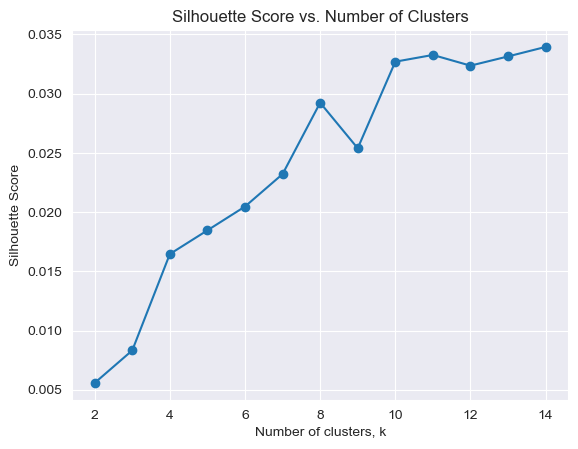

In [267]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
K = range(2, 15)  # 테스트할 군집 개수 범위 설정

for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, random_state=0)
    labels = kmeans.fit_predict(summary_vecs)
    score = silhouette_score(summary_vecs, labels)
    silhouette_scores.append(score)

# 최고점에서 완만하게 내려가는 지점이 최적의 값일수..
# 실루엣 계수 시각화
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()


In [ ]:
# 코사인 유사도 계산을 통해 유사도 행렬을 만든 후, 히트맵 시각화 
# 장르별 문서 간 유사도가 높은 군집이 형성된다면, 장르 특성이 잘 구분되는 것으로 볼 수 있음

In [ ]:
# 써머리=써머리 간 유사도 계산

In [109]:
user_book_df=book_filter_df.pivot_table(index='user_id',columns='book_title',values='rating',fill_value=0)
user_book_df.shape # user간 유사도 구할거 아니니까
book_user_df=user_book_df.T

In [99]:
from sklearn.metrics.pairwise import cosine_similarity
book_similarity=cosine_similarity(book_user_df,book_user_df)
book_similarity_df=pd.DataFrame(book_similarity)

In [100]:
book_filter_df.to_csv("book_filter",index=False, encoding='utf-8')